In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import torchvision
import imageio
import torch

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from LAG import CPS

from PIL import Image
import torch.nn as nn



In [4]:
transform = transforms.Compose([
                transforms.Resize(64),
                transforms.CenterCrop(64),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
dataset = CPS("/home/work/LSGAN_CelebA/LSGAN_CelebA-main/images/CPS_Dog_Cataract", transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, num_workers=0)

In [5]:
def view_samples(images):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

torch.Size([64, 3, 64, 64])


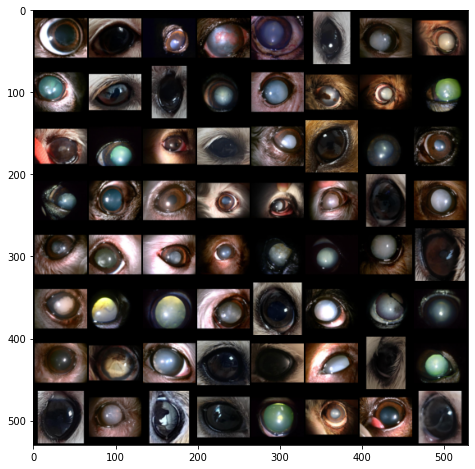

In [6]:
test = iter(dataloader)
sample = next(test)
print(sample.size())
view_samples(sample)

In [7]:
def save_progress(images, epoch, step):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = np.uint8(img*255)
    imageio.imwrite(f"progress_pics_CPS/{epoch}-{step}.jpg", img)

In [8]:
def save_model_state(model, optimizer, loss, epoch, name):
    model_path = f"saved_models/{name}{epoch}.pt"
    state_dict = {
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'training_loss' : loss,
    }
    torch.save(state_dict, model_path)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class DiscriminatorModel(nn.Module):
    def __init__(self, n_c, n_fmps):
        super(DiscriminatorModel, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(n_c, n_fmps, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps, n_fmps*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*2, n_fmps*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*4, n_fmps*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps * 8, 1, 4, stride=1, padding=0),
        )
        self.linear = nn.Linear(1, 1)
        self.net.apply(weights_init)
        self.linear.apply(weights_init)
    def forward(self, x):
        x = self.net(x)
        x = self.linear(x)
        return x.view(-1, 1, 1, 1)

In [10]:
class GeneratorModel(nn.Module):
    def __init__(self, n_z, n_fmps, n_c):
        super(GeneratorModel, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n_z, n_fmps*8, 4, 1, 0),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*8, n_fmps*4, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*4, n_fmps*2, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*2, n_fmps*1, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*1),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps, n_c, 4, 2, 1),
            nn.Tanh()
        )
        self.net.apply(weights_init)

    def forward(self, x):
        x = self.net(x)
        return x

numpy.ndarray

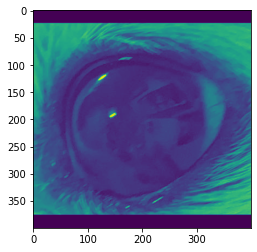

In [18]:
img_sample = color.rgb2gray(io.imread('images/CPS_Dog_Cataract/image4.jpg'))
plt.imshow(img_sample)
type(img_sample)


In [19]:
img_sample.shape

(400, 400)

In [20]:
img_sample2 = color.rgb2gray(io.imread('images/CPS_Dog_Cataract/image5.jpg'))
img_sample3 = color.rgb2gray(io.imread('images/CPS_Dog_Cataract/image6.jpg'))
img_sample4 = color.rgb2gray(io.imread('images/CPS_Dog_Cataract/image7.jpg'))
img_sample5 = color.rgb2gray(io.imread('images/CPS_Dog_Cataract/image8.jpg'))
#img_sample6 = color.rgb2gray(io.imread('D:\workspace\DCGAN\PCA_DCGAN\LAG_dataset\dataset\image6.jpg'))
#img_sample7 = color.rgb2gray(io.imread('D:\workspace\DCGAN\PCA_DCGAN\LAG_dataset\dataset\image7.jpg'))

We can use the numpy ravel function to change the dimensions, that is from a matrix to a long vector of shape (800*800,) = (640000,)

In [21]:
fullvector = img_sample.ravel()
fullvector2 = img_sample2.ravel()
fullvector3 = img_sample3.ravel()
fullvector4 = img_sample4.ravel()
fullvector5 = img_sample5.ravel()
#fullvector6 = img_sample6.ravel()
#fullvector7 = img_sample7.ravel()
print(fullvector.shape)
print(fullvector)


(160000,)
[0. 0. 0. ... 0. 0. 0.]


In [22]:
data_sample = np.array([fullvector,fullvector2,fullvector3,fullvector4,fullvector5])
data_sample = data_sample.T
data_sample.shape


(160000, 5)

While trying to get the variance -covariance matrix for the data, numpy took a lot of time, that is where Pytorch comes in, to convert numpy array into a Pytorch tensor, use torch.as_tensor()

In [23]:
torchtensor = torch.as_tensor(data_sample.T)
type(torchtensor)
torchtensor.shape

torch.Size([5, 160000])

Here is the effiecient implementation of PCA from Pytorch, we use this with the torch tensor.

In [24]:
U,S,V = torch.pca_lowrank(torchtensor, q=None, center=True, niter=3)

In [25]:
U
U.shape

torch.Size([5, 5])

In [26]:
torch.matmul(U, U.T)
print(torch.matmul(U, U.T).shape)

torch.Size([5, 5])


In [27]:
torch.matmul(V.T, V)
print(torch.matmul(V.T, V).shape)

torch.Size([5, 5])


In [28]:
S

tensor([1.4152e+02, 8.6956e+01, 4.4185e+01, 3.9871e+01, 2.0206e-14],
       dtype=torch.float64)

The relation of (U, S, V) to PCA is as follows:
A is a data matrix with m samples and n features
the V columns represent the principal directions

S ** 2 / (m - 1) contains the eigenvalues of A.T * A / (m - 1)

which is the covariance of A when center=True is provided.
matmul(A, V[:, :k]) projects data to the first k principal components

In [29]:
U.shape

torch.Size([5, 5])

In [30]:
S.shape

torch.Size([5])

In [31]:
V.shape

torch.Size([160000, 5])

We are using the K first important principal components and we can vary K, we wish to project the data into a different dimension.

In [32]:
zresult=torch.matmul(torchtensor.T, V.T[:, :10])      # here K = 20  


In [33]:
zresult.shape

torch.Size([160000, 10])

We project back the PCA result to its original dimensions.

In [34]:
xapprox  = torch.matmul(V.T[:, :10], zresult.T)

In [35]:
xapprox.shape

torch.Size([5, 160000])

We separate the samples and reshape the tensors and finally convert them to numpy version to view them as the original image size.

In [36]:
xapprox[0].shape

torch.Size([160000])

In [37]:
ch1=torch.reshape(xapprox[0], (400, 400))
ch2=torch.reshape(xapprox[1], (400, 400))
ch3=torch.reshape(xapprox[2], (400, 400))
ch4=torch.reshape(xapprox[3], (400, 400))
ch5=torch.reshape(xapprox[4], (400, 400))
#ch6=torch.reshape(xapprox[5], (800, 800))

In [38]:
ch1numpy = ch1.numpy()
ch2numpy = ch2.numpy()
ch3numpy = ch3.numpy()
ch4numpy = ch4.numpy()
ch5numpy = ch5.numpy()
#ch6numpy = ch6.numpy()

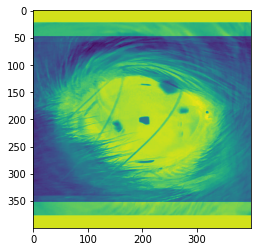

In [39]:
plt.imshow(ch1numpy)
plt.show()

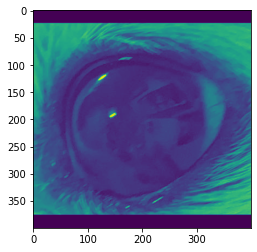

In [40]:
plt.imshow(img_sample)
plt.show()

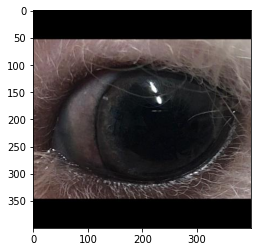

In [42]:
img = io.imread('images/CPS_Dog_Cataract/image0.jpg')
plt.imshow(img)
plt.show()